### Import packages and load data

In [1]:
import numpy as np
import pandas as pd

import re
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import TweetTokenizer
from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

import matplotlib.pyplot as plt 
from wordcloud import WordCloud

[nltk_data] Downloading package punkt to /Users/chuwen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/chuwen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = pd.read_csv("tripadvisor_hotel_reviews.csv", low_memory=False)
df

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5
...,...,...
20486,"best kept secret 3rd time staying charm, not 5...",5
20487,great location price view hotel great quick pl...,4
20488,"ok just looks nice modern outside, desk staff ...",2
20489,hotel theft ruined vacation hotel opened sept ...,1


### Data exploration

#### Class distribution - imbalanced

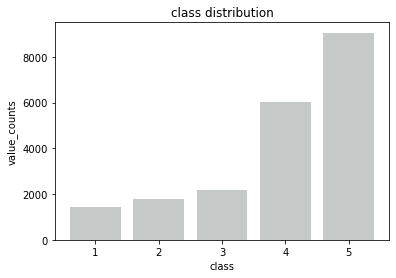

In [3]:
x_class = [i for i in range(1,6)]
y_class = df['Rating'].value_counts().sort_index().tolist()

plt.bar(x_class, y_class, color='#c5c9c7')
plt.title("class distribution") 
plt.ylabel("value_counts") 
plt.xlabel("class") 
plt.show()

#### Average length of review in each class

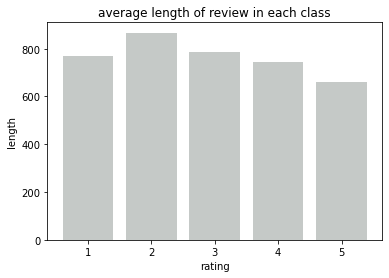

In [4]:
x_len = [i for i in range(1,6)]
y_len = []

for rating in range(1,6):
    df_rating = df[df['Rating'] == rating]
    y_len.append(sum(df_rating['Review'].map(len)) / len(df_rating))
    
plt.bar(x_len, y_len, color='#c5c9c7')
plt.title("average length of review in each class") 
plt.ylabel("length") 
plt.xlabel("rating") 
plt.show()

### Convert 5-star rating to positive and negative scale

In [5]:
df['pos_or_neg'] = [0 if x >= 4 else 1 for x in df['Rating']]
df

,Review,Rating,pos_or_neg
0,nice hotel expensive parking got good deal sta...,4,0
1,ok nothing special charge diamond member hilto...,2,1
2,nice rooms not 4* experience hotel monaco seat...,3,1
3,"unique, great stay, wonderful time hotel monac...",5,0
4,"great stay great stay, went seahawk game aweso...",5,0
...,...,...,...
20486,"best kept secret 3rd time staying charm, not 5...",5,0
20487,great location price view hotel great quick pl...,4,0
20488,"ok just looks nice modern outside, desk staff ...",2,1
20489,hotel theft ruined vacation hotel opened sept ...,1,1


### Remove stopwords, digits, punctuation marks

In [6]:
stop_words = stopwords.words('english')

def data_cleaner(review):
    review = re.sub('\d+',' ', review)  #remove digits
    review = re.sub('[^a-z]+', ' ', review)  #remove punctuation marks
    review = review.replace('room' , '')
    review = review.replace('hotel', '')
    review = review.split()
    review = " ".join([word for word in review if not word in stop_words])  #remove stop words
    return review

df['Review_clean'] = df['Review'].apply(lambda x: data_cleaner(x))

### Generate word cloud

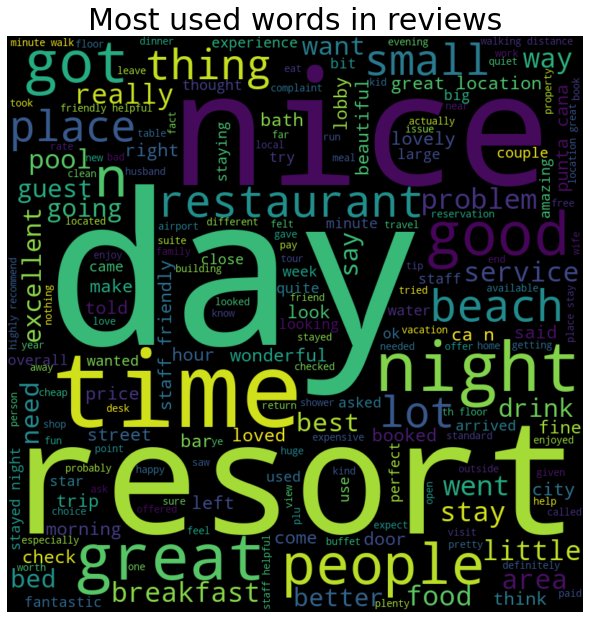

In [7]:
def wordCloud_generator(data, title=None):
    wordcloud = WordCloud(width = 800, height = 800,
                          background_color ='black',
                          min_font_size = 10
                         ).generate(" ".join(data.values))
                           
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud, interpolation='bilinear') 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title(title,fontsize=30)
    plt.show() 

wordCloud_generator(df['Review_clean'], title="Most used words in reviews")

### Apply the TF-IDF approach  to convert texts into feature vector 

In [8]:
tfidf = TfidfVectorizer(ngram_range =(1,5), analyzer = 'word')
X = tfidf.fit_transform(df['Review_clean'])
y = df['pos_or_neg']

### Use SMOTE to oversample the minority classes

In [9]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

sm = SMOTE(random_state=12) 
x_train_words_sm, y_train_words_sm = sm.fit_resample(x_train, y_train)

In [10]:
from collections import Counter
class_check_before = Counter(y_train)    # Counter({0: 12048, 1: 4344})
class_check_after = Counter(y_train_words_sm)   # Counter({0: 12048, 1: 12048})

### Apply SVM model on the dataset

In [11]:
svc = LinearSVC(class_weight='balanced')
svc_fit = svc.fit(x_train_words_sm, y_train_words_sm)
y_pred = svc.predict(x_test)

In [12]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[2965   80]
 [ 338  716]]
              precision    recall  f1-score   support

           0       0.90      0.97      0.93      3045
           1       0.90      0.68      0.77      1054

    accuracy                           0.90      4099
   macro avg       0.90      0.83      0.85      4099
weighted avg       0.90      0.90      0.89      4099

